[dataset](https://drive.google.com/file/d/1FjFQN7-LHAswok9IcheKB6jtxq_xoSZe/view?usp=sharing)

In [ ]:
#Import all libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
import io

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Churn_Modelling.csv to Churn_Modelling.csv
User uploaded file "Churn_Modelling.csv" with length 684858 bytes


In [ ]:
dataset = pd.read_csv(io.BytesIO(uploaded['Churn_Modelling.csv']))
dataset.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#number of rows and attributes
dataset.shape

(10000, 14)

In [ ]:
#drop unusable attributes for further analysis
dataset = dataset.drop(labels=['RowNumber', 'Surname'], axis=1)

In [ ]:
#check for missing values
print("Missing values in the train dataset:\n\n",dataset.isna().sum())

Missing values in the train dataset:

 CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


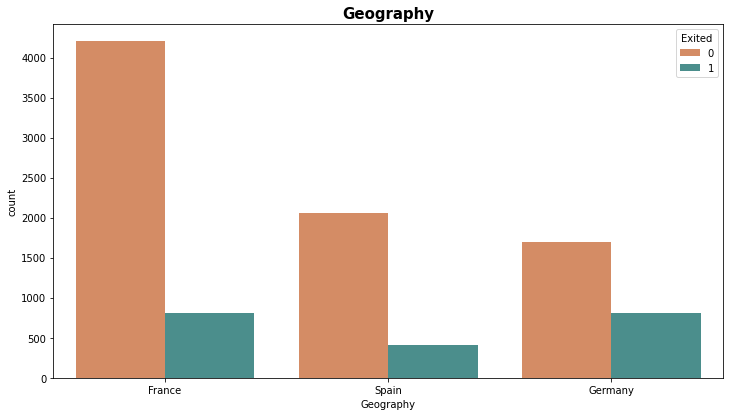

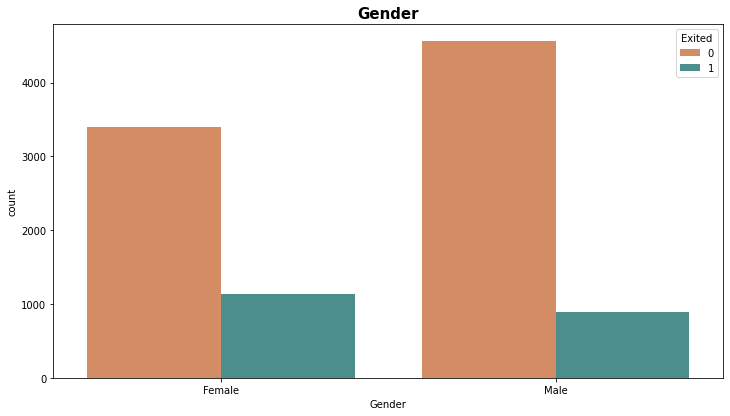

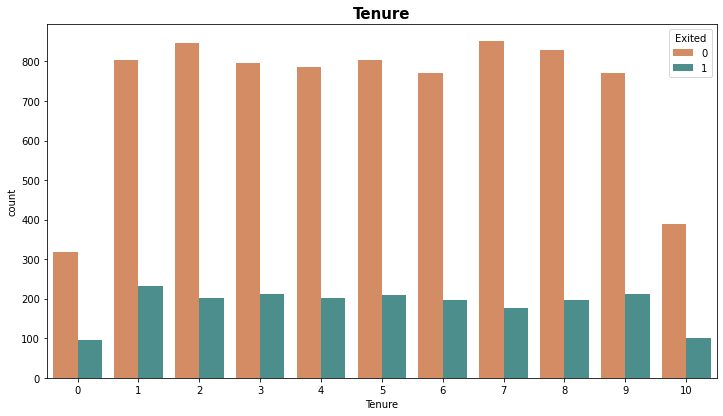

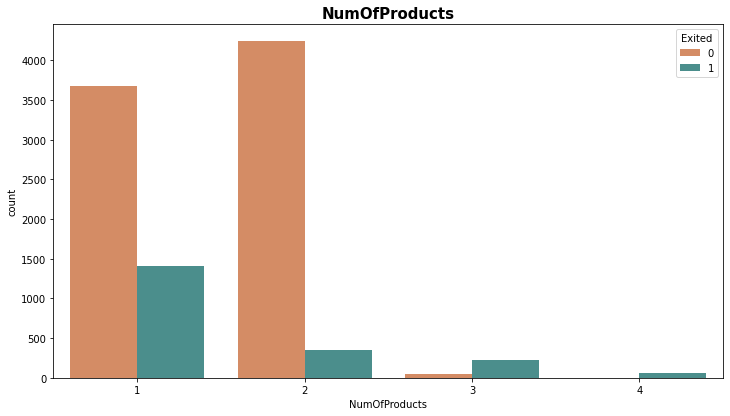

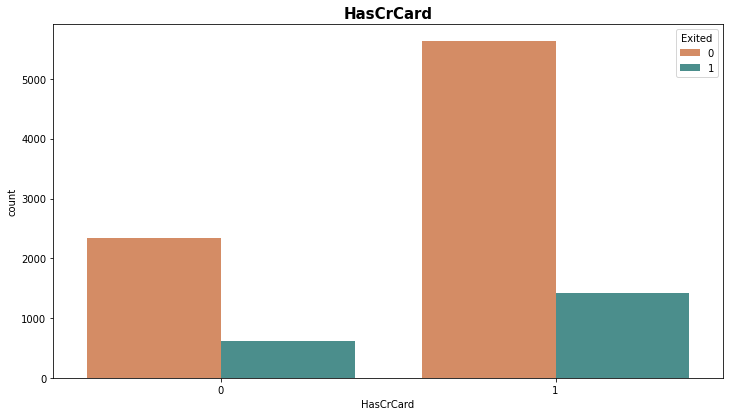

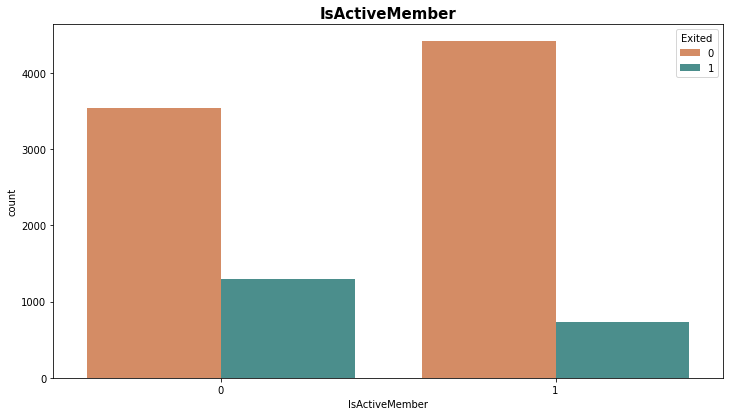

In [ ]:
list_of_cat_features = dataset[['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']]  
palette_features = ['#E68753', '#409996']

for feature in list_of_cat_features:
    plt.figure(figsize=(12,6.5)) 
    plt.title(feature, fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
    ax = sns.countplot(x = list_of_cat_features[feature], hue = 'Exited', data = dataset, palette=palette_features)


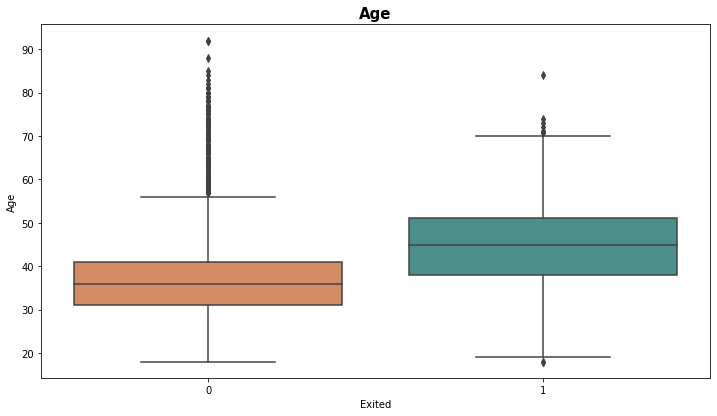

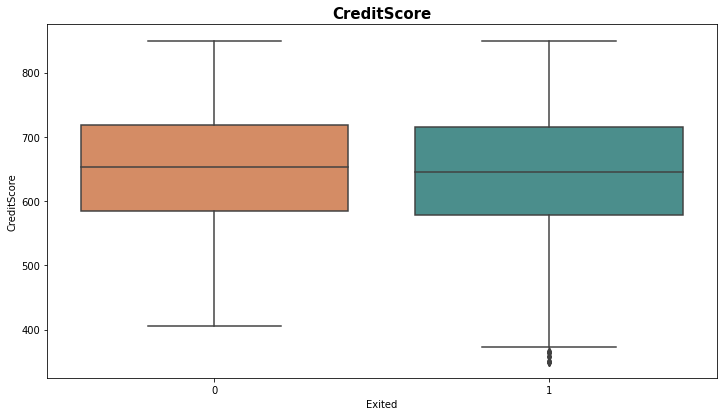

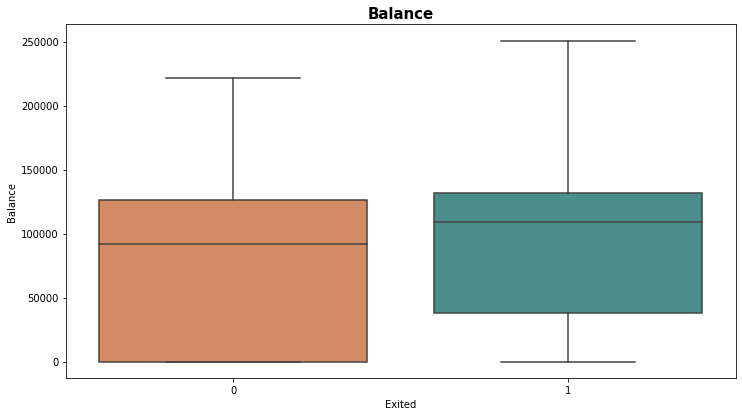

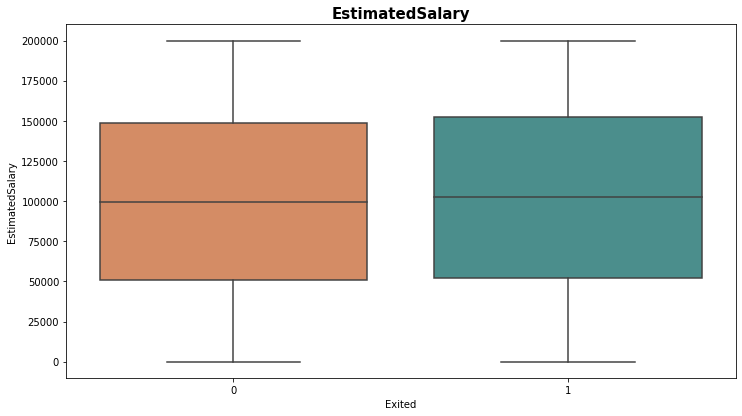

In [ ]:
list_of_num_features = dataset[['Age', 'CreditScore', 'Balance', 'EstimatedSalary']]  
palette_features = ['#E68753', '#409996']

for feature in list_of_num_features:
    plt.figure(figsize=(12,6.5)) 
    plt.title(feature, fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
    ax = sns.boxplot(x = dataset['Exited'], y = list_of_num_features[feature], data = dataset, palette=palette_features)
    #add labels to each bar
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

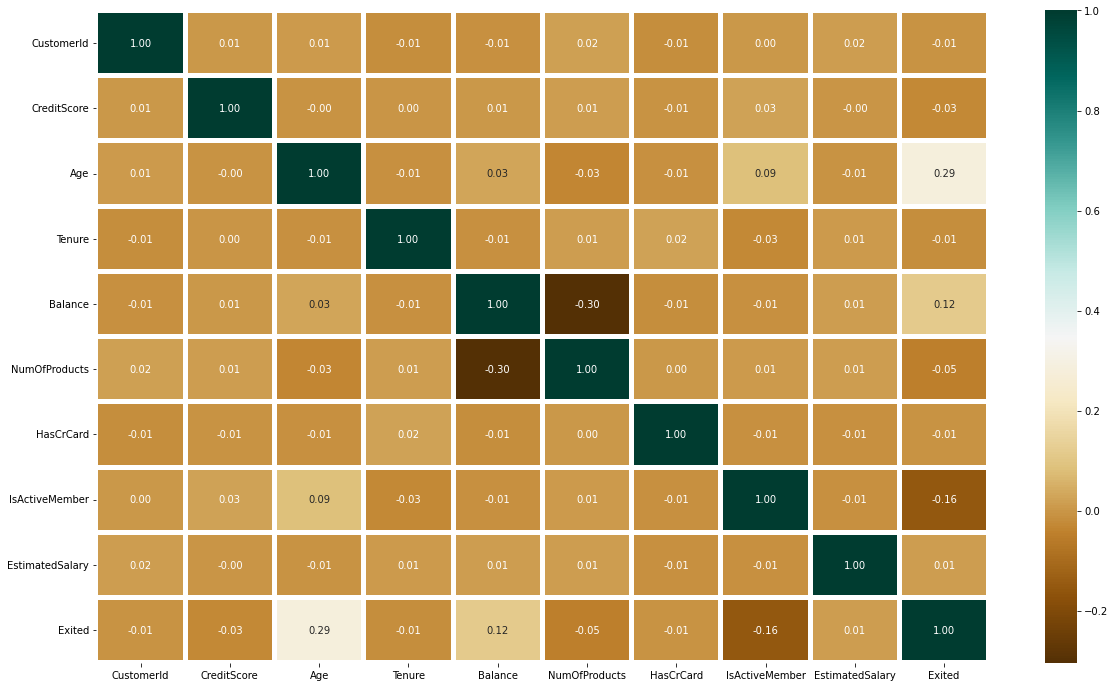

In [ ]:
# plotting heatmap to notice correlations between fetures
corr = dataset.corr()

plt.figure(figsize = (20, 12))
sns.heatmap(corr, linewidths = 4, annot = True, fmt = ".2f", cmap="BrBG")
plt.show()

In [ ]:
#transform all categorical attributes into numerical
cat_columns = [cname for cname in dataset.columns
                        if dataset[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    dataset[col] = encoder.fit_transform(dataset[col])
    
dataset.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
#balancing the target variable
columns = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Exited']
columns = [c for c in columns if c not in ['Exited']]
y = dataset['Exited'] #prior target variable
X = dataset[columns]  #prior features

ros = RandomOverSampler(sampling_strategy='minority')
X_train_balanced, y_train_balanced = ros.fit_resample(X, y) #y_train as balanced target variable
print(f"Imbalanced target class: {Counter(y)}\n\nBalanced target class: {Counter(y_train_balanced)}\n")
print(X_train_balanced.shape[0] - dataset.shape[0], 'new random picked points')

Imbalanced target class: Counter({0: 7963, 1: 2037})

Balanced target class: Counter({1: 7963, 0: 7963})

5926 new random picked points


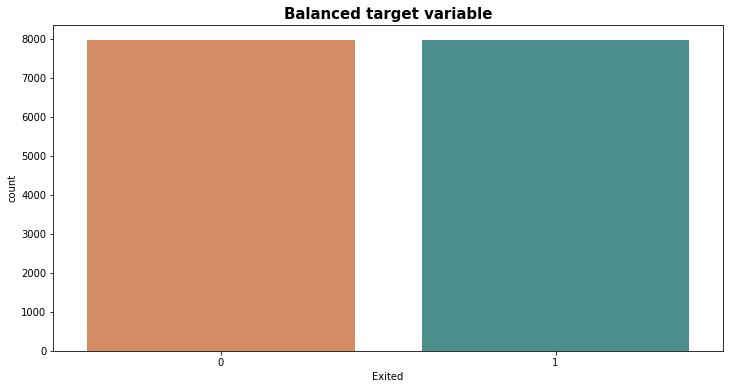

In [ ]:
#plot the balanced target variable
plt.figure(figsize=(12,6))
plt.title("Balanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x=y_train_balanced, data=dataset, palette=palette_features)
plt.show()

In [ ]:
#preparation of train and test data for ML models
X_train,X_test,y_train,y_test = train_test_split(X_train_balanced, y_train_balanced,test_size=0.3, random_state = 1) #70 % of train data, 30 % of test data
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((11148, 9), (4778, 9), (11148,), (4778,))

In [ ]:
#implementing Random forest
rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
print("Accuracy score of Random forest : {:.2f}".format(accuracy_score(y_pred_rfc,y_test)))
print("Recall score of Random forest : {:.2f}".format(recall_score(y_pred_rfc,y_test,average='macro',zero_division=True)))
print("Precision score of Random forest : {:.2f}".format(precision_score(y_pred_rfc,y_test,zero_division = True)))
print("F1 score of Random forest : {:.2f}".format(f1_score(y_pred_rfc,y_test,zero_division=True)))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      2322
           1       0.91      0.97      0.93      2456

    accuracy                           0.93      4778
   macro avg       0.93      0.93      0.93      4778
weighted avg       0.93      0.93      0.93      4778

Accuracy score of Random forest : 0.93
Recall score of Random forest : 0.93
Precision score of Random forest : 0.97
F1 score of Random forest : 0.93


[[2076  246]
 [  84 2372]]


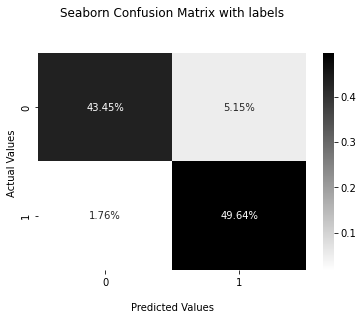

In [ ]:
cf_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)
print(cf_matrix_rfc)
ax = sns.heatmap(cf_matrix_rfc/np.sum(cf_matrix_rfc), annot=True, fmt='.2%', cmap='binary')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()